# Pytorch Homework 3: 利用 stanford dog (mini) dataset 來訓練一個分類器。

## 作業說明

這次的作業總共有 4 個部份，必須完成助教提供的 ipynb 檔，在檔案中某些區塊會有 ??? 處需要完成。

0. 安裝需要使用的 package: pip install -r requirements.txt

1. 實作 Dataloader
    * 1.1. 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset。 ** (10%) **
    * 1.2. 將每一個類別以 8 : 2 的比例分割成 Training data 和 Testing data 傳至 dataloader  ** (15%) **

2. 建構 CNN model。
    * 2.1. 利用 Pytorch 內建的 CNN model 來進行訓練。 ** (10%) **
    * 2.2. 自行設計一個新的 CNN model 來進行訓練。 ** (20%) ** (至少達到 70% 以上的 Testing accuracy，否則只有一半的分數)
    * 2.3. 利用 torchsummary 來印出上面兩個模型的架構資訊。 ** (5%) **

3. 實作模型訓練和測試模型效能。 ** (30%) **
4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖並儲存下來。 ** (10%) **
    
## 作業繳交

* Deadline : 11/16 中午12:00        
    * **遲交一天打 7 折**
    * **遲交兩天打 5 折**
    * **遲交三天以上不給予分數**
    
* 繳交方式 : 請將完成的 ipynb 檔 (分成兩個版本: 內建 model 版和自己設計的版本) 以及 Loss、Training / testing accuracy 的圖片，壓縮後上傳至 moodle。
    * 建議先完成一個版本，然後將檔案複製後再完成另一個版本
    
* 壓縮檔內包含 :
    * (你的學號)\_(姓名)\_HW3_2_1.ipynb  (E.g.F77777777_王小明_HW3_2_1.ipynb) 
    * (你的學號)\_(姓名)\_HW3_2_2.ipynb  (E.g.F77777777_王小明_HW3_2_2.ipynb) 
    * 兩個版本的 Loss.png、Acc.png (Loss_2_1.png、Loss_2_2.png、Acc_2_1.png、Acc_2_2.png)
    * **格式不對的話會扣 10 分！！！**
    
* 有任何問題歡迎寄信至我的信箱
    * 曹維廷 a0903511820@gmail.com

In [ ]:
!pip install -r requirements.txt

In [3]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Part 1：Dataloader 實作

In [5]:
# 1.1. 填入 ??? 的部份

class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames # 資料集的所有檔名
        self.labels = labels # 影像的標籤
        self.transform = transform # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames) # return DataSet 長度
 
    def __getitem__(self, idx):
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) # Transform image
        label = np.array(self.labels[idx])
                
        return image, label # return 模型訓練所需的資訊


In [6]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

# 1.2. 填入 ??? 的部份

def split_Train_Val_Data(data_dir):
    
    dataset = ImageFolder(data_dir) 
    
    # 建立 20 類的 list
    character = [[] for i in range(len(dataset.classes))]
    #print(character)
    
    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples:       
        character[y].append(x)
      
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        
        np.random.seed(42)
        np.random.shuffle(data)
            
        # -------------------------------------------
        # 將每一類都以 8:2 的比例分成訓練資料和測試資料
        # -------------------------------------------
        
        num_sample_train = int(len(data) * 0.8)
        num_sample_test = len(data)-num_sample_train
        
        #print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))
        
        for x in data[:num_sample_train] : # 前 80% 資料存進 training list
            train_inputs.append(x)
            train_labels.append(i)
            
        for x in data[num_sample_test:] : # 後 20% 資料存進 testing list
            test_inputs.append(x)
            test_labels.append(i)

    train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                  batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
                                  batch_size = batch_size, shuffle = False)
 
    return train_dataloader, test_dataloader

### Part 2: 建立 CNN Model

### Setting

依據需求調整參數

In [8]:
batch_size = 32
lr = 1e-3
epochs = 20

data_dir = 'stanford_dog'

In [10]:
# 2.3. 

train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096,20)
vgg16 = vgg16.cuda()
    
C = vgg16.to(device) # 使用內建的 model 或是自行設計的 model
optimizer_C = optim.SGD(C.parameters(), lr = lr) # 選擇你想用的 optimizer

summary(C,(3,224,224)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

# Loss function
criteron = nn.CrossEntropyLoss() # 選擇想用的 loss function

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

### 3. 實作模型訓練和測試模型效能

In [12]:
if __name__ == '__main__':    
    
    for epoch in range(epochs):
    
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
                        
            optimizer_C.zero_grad() # 清空梯度
            
            output = C(x) # 將訓練資料輸入至模型進行訓練
            loss = criteron(output,label) # 計算 loss
            
            loss.backward() # 將 loss 反向傳播
            optimizer_C.step() # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(output.data,1)
            total_train += len(label)
            correct_train += (predicted == label).sum()

            train_loss_C += loss.item()
            iter += 1

            
        training_accuracy = correct_train / total_train
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad(): # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                
                output = C(x) # 將測試資料輸入至模型進行測試
                 # 計算測試資料的準確度
                _, predicted = torch.max(output.data,1)
                total_test += len(label)
                correct_test += (predicted == label).sum()

                
        testing_accuracy = correct_test / total_test
        print('Testing acc: %.3f' % (correct_test / total_test))
                                     
        train_acc.append(100 * training_accuracy) # training accuracy
        test_acc.append(100 * testing_accuracy)  # testing accuracy
        loss_epoch_C.append(train_loss_C) # loss 
    

epoch: 1 / 20
Training epoch: 1 / loss_C: 2.501 | acc: 0.299
Testing acc: 0.764
epoch: 2 / 20
Training epoch: 2 / loss_C: 1.728 | acc: 0.591
Testing acc: 0.843
epoch: 3 / 20
Training epoch: 3 / loss_C: 1.405 | acc: 0.668
Testing acc: 0.856
epoch: 4 / 20
Training epoch: 4 / loss_C: 1.225 | acc: 0.699
Testing acc: 0.865
epoch: 5 / 20
Training epoch: 5 / loss_C: 1.129 | acc: 0.707
Testing acc: 0.874
epoch: 6 / 20
Training epoch: 6 / loss_C: 1.072 | acc: 0.710
Testing acc: 0.877
epoch: 7 / 20
Training epoch: 7 / loss_C: 0.995 | acc: 0.725
Testing acc: 0.885
epoch: 8 / 20
Training epoch: 8 / loss_C: 0.948 | acc: 0.748
Testing acc: 0.882
epoch: 9 / 20
Training epoch: 9 / loss_C: 0.916 | acc: 0.744
Testing acc: 0.888
epoch: 10 / 20
Training epoch: 10 / loss_C: 0.919 | acc: 0.744
Testing acc: 0.888
epoch: 11 / 20
Training epoch: 11 / loss_C: 0.886 | acc: 0.749
Testing acc: 0.890
epoch: 12 / 20
Training epoch: 12 / loss_C: 0.869 | acc: 0.740
Testing acc: 0.889
epoch: 13 / 20
Training epoch: 13 

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

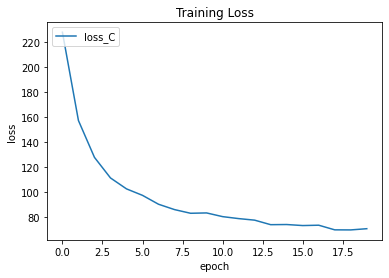

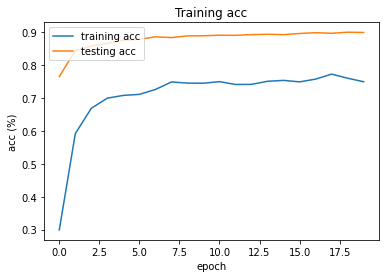

In [17]:
plt.figure()

plt.plot(loss_epoch_C) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
#plt.savefig("Loss_2_2.png")
plt.show()


plt.figure()

plt.plot(np.array(train_acc)/100) # plot your training accuracy
plt.plot(np.array(test_acc)/100) # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
#plt.savefig("Acc_2_2.png")
plt.show()
